## DeepLab V1: Semantic Image Segmentation with Deep Convolutional Nets and Fully Connected CRFs, ICLR 2015

- Atrous convolution은 기존 convolution과 다르게 필터 내부에 빈 공간을 둔 채로 작동
- 기존 convolution과 동일한 양의 파라미터와 계산량을 유지하면서 field of view (한 픽셀이 볼 수 있는 영역)를 크게 가져갈 수 있음
- Semantic segmentation에서 일반적으로 높은 성능을 내기 위해서는 convolutional neural network의 마지막에 존재하는 한 픽셀이 입력값에서 어느 크기의 영역을 커버할 수 있는지를 결정하는 receptive field 크기가 중요
- Atrous convolution을 활용하면 파라미터 수를 늘리지 않으면서도 receptive field를 크게 키울 수 있기 때문에 DeepLab 계열에서는 이를 적극적으로 활용


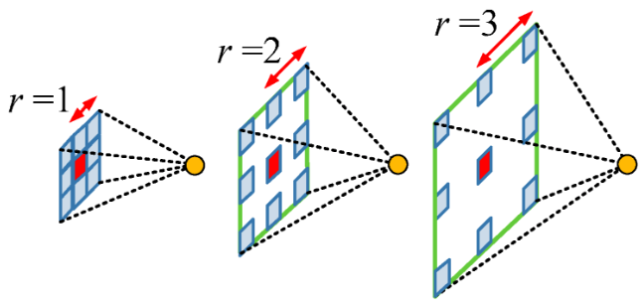

## DeepLab V2: DeepLab: Semantic Image Segmentation with Deep Convolutional Nets, Atrous Convolution, and Fully Connected CRFs, TPAMI 2017

- Semantic segmentaion의 성능을 높이기 위한 방법 중 하나로, spatial pyramid pooling 기법을 자주 사용
- Feature map으로부터 여러 개의 rate가 다른 atrous convolution을 병렬로 적용한 뒤, 이를 다시 합쳐주는 atrous spatial pyramid pooling (ASPP) 기법을 활용
- multi-scale context를 모델 구조로 구현하여 보다 정확한 semantic segmentation을 수행할 수 있도록 함

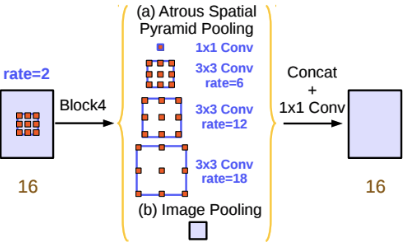

## DeepLab V3: Rethinking Atrous Convolution for Semantic Image Segmentation, arXiv 2017.

- Encoder: ResNet with Atrous convolution
- Atrous Spatial Pyramid Pooling (ASPP)
- Decoder: Bilinear Upsampling

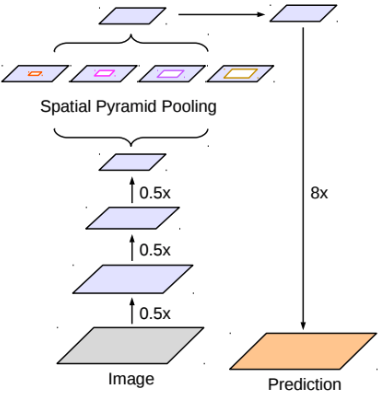

## DeepLab V3+: Encoder-Decoder with Atrous Separable Convolution for Semantic Image Segmentation, arXiv 2018.

- Encoder: ResNet with Atrous Convolution → Xception (Inception with Separable Convolution)
- ASPP → ASSPP (Atrous Separable Spatial Pyramid Pooling)
- Decoder: Bilinear Upsampling → Simplified U-Net style decoder  

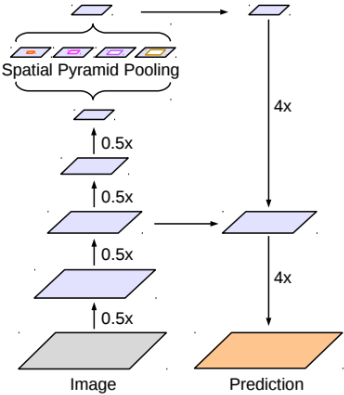

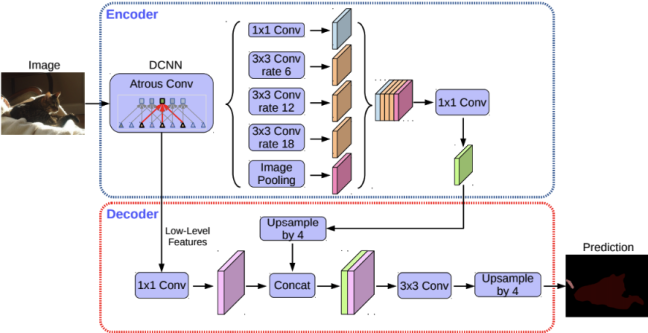

# Data prepare

In [12]:
import os
import cv2
import numpy as np
from glob import glob
from scipy.io import loadmat
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img

In [2]:
# !gdown https://drive.google.com/uc?id=1B9A9UCJYMwTL4oBEo4RZfbMZMaZhKJaz
# !unzip -q instance-level-human-parsing.zip

In [3]:
IMAGE_SIZE = 512
BATCH_SIZE = 4
NUM_CLASSES = 20
DATA_DIR = "./instance-level_human_parsing/instance-level_human_parsing/Training"
NUM_TRAIN_IMAGES = 10000
NUM_VAL_IMAGES = 50

In [4]:
train_images = sorted(glob(os.path.join(DATA_DIR, 'Images/*')))[:NUM_TRAIN_IMAGES]
train_masks = sorted(glob(os.path.join(DATA_DIR, 'Category_ids/*')))[:NUM_TRAIN_IMAGES]

val_images = sorted(glob(os.path.join(DATA_DIR, 'Images/*')))[NUM_TRAIN_IMAGES: NUM_VAL_IMAGES+NUM_TRAIN_IMAGES]
val_masks = sorted(glob(os.path.join(DATA_DIR, 'Category_ids/*')))[NUM_TRAIN_IMAGES: NUM_VAL_IMAGES+NUM_TRAIN_IMAGES]

In [5]:
def read_image(image_path, mask=False):
    image = tf.io.read_file(image_path)
    if mask:
        image = tf.image.decode_png(image, channels=1)
        image.set_shape([None, None, 1])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
        
    else:
        image = tf.image.decode_png(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = image / 127.5 - 1
        
    return image

def load_data(image_list, mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    return image, mask

def data_generator(image_list, mask_list):
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder = True)
    return dataset

In [6]:
train_dataset = data_generator(train_images, train_masks)
val_dataset = data_generator(val_images, val_masks)

print (f"Train Dataset: {train_dataset}")
print(f"Val Dataset: {val_dataset}")

Train Dataset: <BatchDataset shapes: ((4, 512, 512, 3), (4, 512, 512, 1)), types: (tf.float32, tf.float32)>
Val Dataset: <BatchDataset shapes: ((4, 512, 512, 3), (4, 512, 512, 1)), types: (tf.float32, tf.float32)>


# Create Model

- 인코더-디코더 구조를 확장
    - 인코더 모듈: 확장된 컨볼루션을 여러 척도로 적용하여 다중 스케일 상황 정보 처리
    - 디코더 모듈: 객체 경계를 따라 분할 결과 조정

- 확장된 컨볼루션(Dilated convolution)
    - 컨볼루션 확장을 통해 네트워크 깊숙히 들어가며 스트라이드를 일정하게 유지 가능
    - 매개변수의 수나 계산량을 늘리지 않고도 더 큰 시야를 가질 수 있음
    - 더 큰 특징 맵 출력이 가능하여 세그멘테이션에 유용함

- 확장된 공간 피라미드 풀링(Dilated Spatial Pyramid Pooling)
  - 샘플링 속도가 커질수록 유효한 필터 가중치(유효한 특징 영역에 적용되는 가중치)의 수가 작아짐


In [7]:
def convolution_block(block_input, num_filters=256, kernel_size=3,
                      dilation_rate=1, padding='same', use_bias=False):
    x = layers.Conv2D(num_filters, kernel_size=kernel_size, dilation_rate=dilation_rate,
                      padding='same', use_bias=use_bias, kernel_initializer=keras.initializers.HeNormal())(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)

In [8]:
def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size = 1, use_bias=True)
    out_pool = layers.UpSampling2D(size=(dims[-3] // x.shape[1], dims[-2]//x.shape[2]),
                                  interpolation='bilinear')(x)
    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)
    
    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output


- pretrained ResNet50을 backbone model로 사용
- conv4_block6_2_relu 블록에서 저수준의 특징 사용
- 인코더 특징은 인자 4에 의해 쌍선형 업샘플링
- 동일한 공간 해상도를 가진 네트워크 백본에서 저수준 특징과 연결

In [9]:
def DeeplabV3(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    resnet50 = keras.applications.ResNet50(weights='imagenet', include_top=False, input_tensor=model_input)
    
    x = resnet50.get_layer('conv4_block6_2_relu').output
    x = DilatedSpatialPyramidPooling(x)
    
    # upsample by 4
    input_a = layers.UpSampling2D(size=(image_size // 4 // x.shape[1],
                                        image_size // 4 // x.shape[2]),
                                 interpolation='bilinear')(x)
    
    # 1x1 conv (low level feature)
    input_b = resnet50.get_layer('conv2_block3_2_relu').output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)
    
    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(size=(image_size //  x.shape[1],
                                image_size // x.shape[2]),
                            interpolation='bilinear')(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1,1), padding='same')(x)
    return keras.Model(inputs=model_input, outputs=model_output)

model = DeeplabV3(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)
model.summary()
    

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 256, 256, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

# Train Model

In [10]:
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
             loss=loss,
             metrics=['accuracy'])
history = model.fit(train_dataset, validation_data=val_dataset, epochs=20)

Epoch 1/20
2500/2500 [==============================] - 21799s 9s/step - loss: 0.8684 - accuracy: 0.7236 - val_loss: 0.8051 - val_accuracy: 0.7407
Epoch 2/20
2500/2500 [==============================] - 21792s 9s/step - loss: 0.6907 - accuracy: 0.7761 - val_loss: 0.6944 - val_accuracy: 0.7688
Epoch 3/20
2500/2500 [==============================] - 21934s 9s/step - loss: 0.6170 - accuracy: 0.7995 - val_loss: 0.7190 - val_accuracy: 0.7662
Epoch 4/20
2500/2500 [==============================] - 21980s 9s/step - loss: 0.5602 - accuracy: 0.8180 - val_loss: 0.6665 - val_accuracy: 0.7799
Epoch 5/20
2500/2500 [==============================] - 22269s 9s/step - loss: 0.5113 - accuracy: 0.8345 - val_loss: 0.6897 - val_accuracy: 0.7800
Epoch 6/20
2500/2500 [==============================] - 22043s 9s/step - loss: 0.4738 - accuracy: 0.8475 - val_loss: 0.6226 - val_accuracy: 0.8052
Epoch 7/20
2500/2500 [==============================] - 21977s 9s/step - loss: 0.4388 - accuracy: 0.8594 - val_loss: 0

KeyboardInterrupt: 

In [13]:
loss = history.history['loss']
val_loss = history.history['val_loss']

fig = plt.figure(figsize=(12,15))

ax1 = fig.add_subplot(1,2,1)
ax1.plot(loss, color='blue', label='train_loss')
ax1.plot(val_loss, clolr='red', label='val_loss')
ax1.set_title("Train, Val loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("loss")

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

ax2 = fig.add_subplot(1,2,1)
ax2.plot(loss, color='blue', label='train_accuracy')
ax2.plot(val_loss, clolr='red', label='val_accuracy')
ax2.set_title("Train, Val Accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("accuracy")
ax2.grid()
ax2.legend()

plt.show()

NameError: name 'history' is not defined

# Inference

In [14]:
colormap = loadmat('./instance-level_human_parsing/instance-level_human_parsing/human_colormap.mat')['colormap']
colormap = colormap * 100
colormap = colormap.astype(np.uint8)

In [15]:
def infer(model, image_tensor):
    predictions = model.predict(np.expand_dims((image_tensor), axis=0))
    predictions = np.squeeze(predictions)
    predictions = np.argmax(predictions, axis=2)
    return predictions

In [16]:
def decode_segmentation_masks(mask, colormap, n_classes):
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    for i in range(0, n_classes):
        idx = mask==i
        r[idx] = colormap[i, 0]
        g[idx] = colormap[i, 1]
        b[idx] = colormap[i, 2]
    rgb = np.stack([r,g,b], axis = 2)

    return rgb

In [17]:
def get_overlay(image, colored_mask):
    image = tf.keras.preprocessing.image.array_to_img(image)
    image = np.array(image).astype(np.uint8)
    overlay = cv2.addWeighted(image, 0.35, colored_mask, 0.65, 0)
    return overlay

In [18]:
def plot_samples_matplotlib(display_list, figsize=(5, 3)):
    _, axes = plt.subplots(nrows=1, ncols=len(display_list), figsize=figsize)
    for i in range(len(display_list)):
        if display_list[i].shape[-1]==3:  # 정답이면
            axes[i].imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        else:
            axes[i].imshow(display_list[i])
    plt.show()

In [21]:
def plot_predictions(images_list, colormap, model):
    for image_file in images_list:
        image_tensor = read_image(image_file)
        prediction_mask = infer(image_tensor=image_tensor, model=model)
        prediction_colormap = decode_segmentation_masks(prediction_mask, colormap, 20)
        overlay = get_overlay(image_tensor, prediction_colormap)
        plot_samples_matplotlib([image_tensor, overlay, prediction_colormap], figsize=(18, 24))

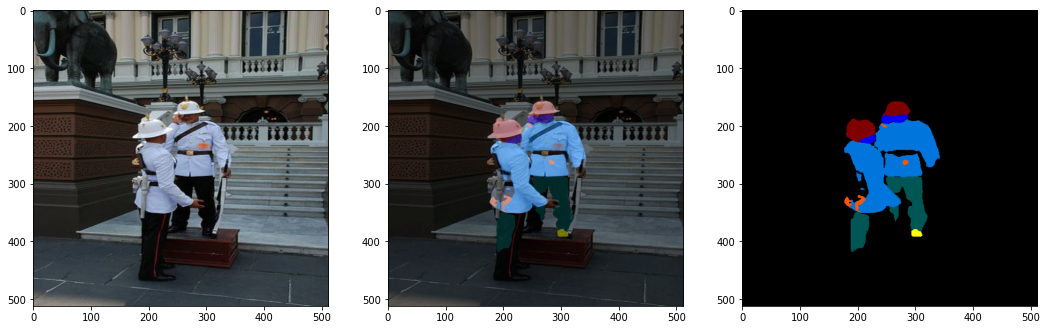

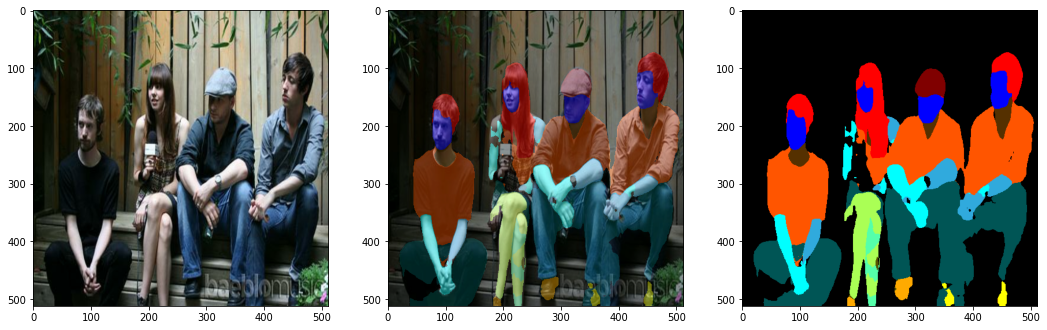

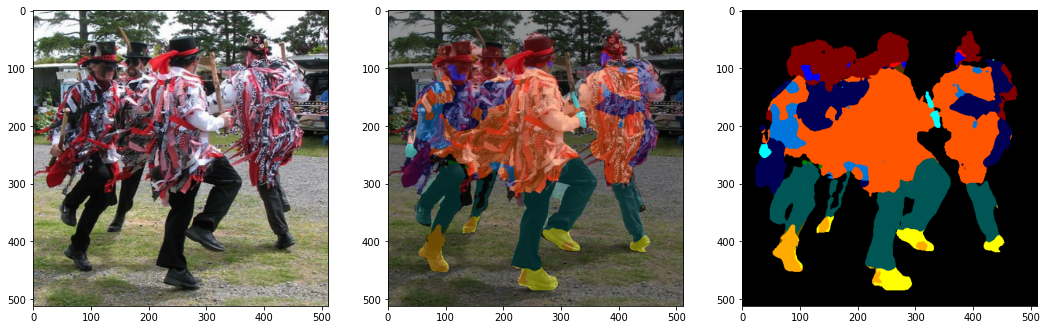

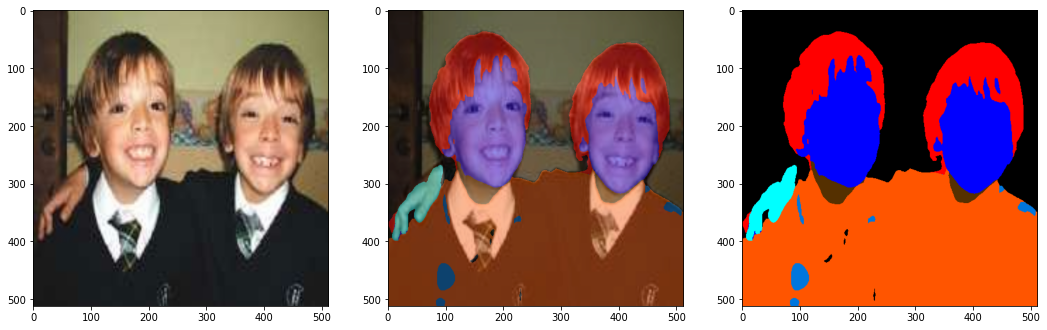

In [22]:
# train 결과 확인
plot_predictions(train_images[:4], colormap, model=model)

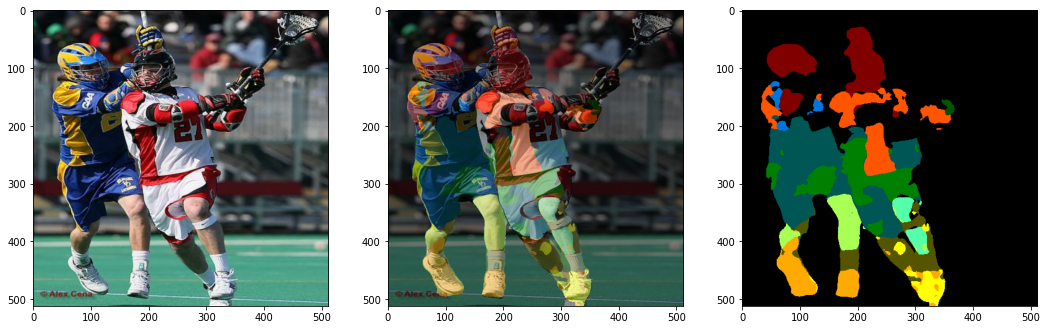

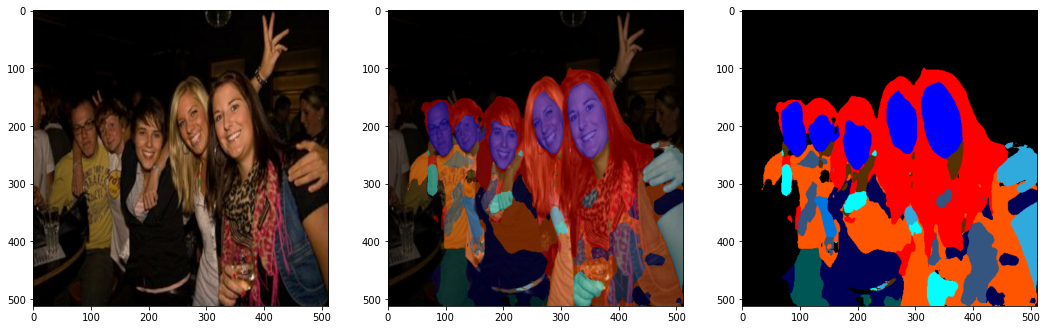

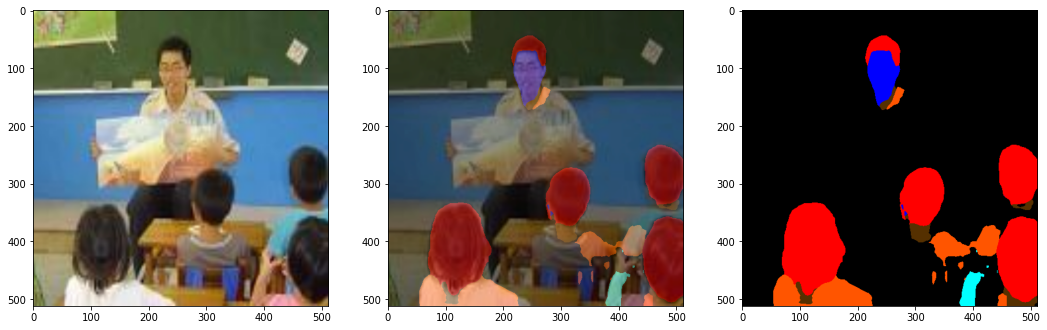

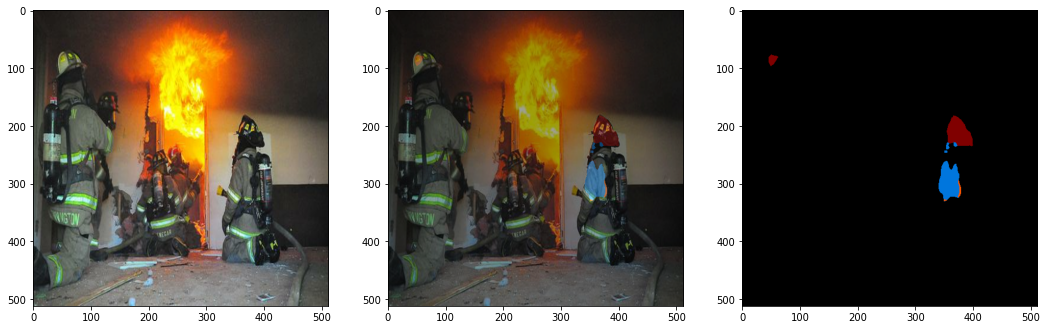

In [23]:
# Validataion 결과 확인
plot_predictions(val_images[:4], colormap, model=model)